# [LEGALST-190] Lab 4/12: Morality and Sentiment Analysis

This lab will cover morality and sentiment analysis using the *Moral Foundations Theory* with dictionary-based analysis, connecting to topic modeling and classifications ideas from previous labs.

### Table of Contents
[The Data](#section data)<br>
[Goal and Question](#section goal)<br>
1 - [Text Pre-processing](#section 1)<br>
2 - [Polarity](#section 2)<br>
3 - [Moral Foundations Theory](#section 3)<br>
4 - [Non-negative matrix factorization](#section 4)<br>

**Dependencies:**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json

from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.stem.snowball import SnowballStemmer

import seaborn as sns

!pip install textblob
from textblob import TextBlob

----
## The Data<a id='section data'></a>

For this lab, we'll use the Old Bailey dataset, something you all should be familiar with now. The size of the dataset is also rather large so we will compare two year-long periods, one from before 1827 and one after. Read the question to better understand why we look at 1827.

## Goal and Question<a id='section goal'></a>

The goal of today's lab is to explore sentiment analysis with three different approaches – [polarity scoring](#section 2), [topic-specific dictionary methods](#section 3), and [topic modeling](#section 4).

We'll look at sentiment in the context of the following question: 

**Did the way judges, prosecutors, and witnesses talk about moral culpability change after the Bloody Code was mostly repealed in 1827 (at the leading edge of a wave of legal reform in England)?**

*Note: this is a question that could encompass an entire research project. Today's lab uses a very small subset of data due to datahub memory limitations, and skips over many of the steps needed for truly robust conclusions. *

Something to think about: What are some things you would need to consider before answering this question?

----

## Section 1: Text Pre-processing<a id='section 1'></a>

### Before we start
This dataset we are about to look at is incredibly large, so to avoid crashing our datahub kernel, we only consider two years: 1822 and 1832. These two years were chosen as periods that were equally far from 1827 (when the Bloody Code was mostly repealed), while not being so far from each other that we'd expect to see major language usage change due only to time.


----

### Getting started

Let's get working with the data.

In [2]:
# contains Old Bailey trial data from 1822 and 1832
old_bailey = pd.read_csv('data/obc_1822_1832.csv', index_col='trial_id')
# select only the columns we need for this lab 
old_bailey = old_bailey.loc[:, ['year', 'transcript']]
old_bailey.head()

,year,transcript
trial_id,,
t18170115-1,1822,"PETER JOHNSON was indicted for being at large,..."
t18170115-2,1822,BENJAMIN HEARNE was indicted for burglariously...
t18170115-3,1822,"JOHN DAVIS and JAMES LEMON , were indicted for..."
t18170115-4,1822,"RICHARD WILTSHIRE and SUSAN PAR-SONS , were in..."
t18170115-5,1822,MARY JOHNSTON was indicted for burglariously b...


Awesome! We now have data we can work with. Before we start anything, we must clean the text!

Just to review, we want to process our text by:<br>
1) Lowercasing the words<br>
2) Cleaning up punctuation<br>
3) Splitting into individual words<br>
4) Stemming the word tokens<br>

For the sake of time (and to get to the good stuff), we've provided the pre-processing code below. This a big data set, so the code will take up to a minute to run.

In [3]:
# pre-process the data
lower_cased = old_bailey['transcript'].str.lower()
punct_re = r'[^\w\s]'
lower_no_punc = lower_cased.str.replace(punct_re, ' ')
tokens = lower_no_punc.str.split()
old_bailey['tokens'] = tokens
stemmer = SnowballStemmer('english')
stem_lists = []

for token_list in old_bailey['tokens']:
    stem_lists.append([stemmer.stem(wd) for wd in token_list])

old_bailey['stemmed_tokens'] = stem_lists


old_bailey.head()

,year,transcript,tokens,stemmed_tokens
trial_id,,,,
t18170115-1,1822,"PETER JOHNSON was indicted for being at large,...","[peter, johnson, was, indicted, for, being, at...","[peter, johnson, was, indict, for, be, at, lar..."
t18170115-2,1822,BENJAMIN HEARNE was indicted for burglariously...,"[benjamin, hearne, was, indicted, for, burglar...","[benjamin, hearn, was, indict, for, burglari, ..."
t18170115-3,1822,"JOHN DAVIS and JAMES LEMON , were indicted for...","[john, davis, and, james, lemon, were, indicte...","[john, davi, and, jame, lemon, were, indict, f..."
t18170115-4,1822,"RICHARD WILTSHIRE and SUSAN PAR-SONS , were in...","[richard, wiltshire, and, susan, par, sons, we...","[richard, wiltshir, and, susan, par, son, were..."
t18170115-5,1822,MARY JOHNSTON was indicted for burglariously b...,"[mary, johnston, was, indicted, for, burglario...","[mari, johnston, was, indict, for, burglari, b..."


----

## Section 2: Polarity <a id='section 2'></a>

One way to measure the tone of a text is to look at the text **polarity**: a measure of how positive or negative it is perceived to be. For example, a sentence like "I love Berkeley!" would be considered positive, while a sentence like "Stanford is terrible!" would be negative. And, because polarity is represented as a scale, some words have stronger positive or negative sentiment than others- "I like data science" is positive, but not as positive as "I love data science."

We will use the [TextBlob](https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis) tools to analyze the sentiment of Old Bailey. TextBlob provides access to many common text-processing operations, and includes a  lexicon and rule-based sentiment analysis tool.

A TextBlob is created around string of text:

In [4]:
# creates a sentiment analyzer
blob = TextBlob("This is a super exciting, totally awesome test sentence.")
blob

TextBlob("This is a super exciting, totally awesome test sentence.")

We can access the sentiment by using `.sentiment`.

In [5]:
blob.sentiment

Sentiment(polarity=0.5444444444444444, subjectivity=0.8222222222222223)

`sentiment` returns two values: the **polarity** and the **subjectivity**. The polarity ranges between -1 and 1 where -1 is a very negative text and 1 is a very positive text. Subjectivity ranges between 0 and 1 where 0 is a very objective text and 1 is a very subjective text (i.e. one that can be interpreted many different ways). You can get the polarity by using `.polarity`.

In [6]:
blob.sentiment.polarity

0.5444444444444444

Polarity is calculated fairly simply: TextBlob accesses a dictionary of words that have been assigned polarity and subjectivity scores, looks up each word in the given text, and averages over the sentence. It also employs a few rules, such as changing the polarity of a word that comes after a negation.

In [7]:
happy = TextBlob('Happy')
print(happy.sentiment.polarity)

negation = TextBlob('Not')
print(negation.sentiment.polarity)

negated_happy = TextBlob('Not happy')
print(negated_happy.sentiment.polarity)

0.8
0.0
-0.4


**QUESTION:** Try calculating the polarity scores of a few of your own sentences in the cell below.

In [8]:
# test the polarity scoring for different sentences
my_blob = ...
...

Ellipsis

Next, we want to get the average polarity for each transcript. 

**EXERCISE:** define a function that will take in a string of text and return the polarity of that text.

In [9]:
def get_polarity(text):
    """Return the polarity of TEXT"""
    ...
    return ...

In [10]:
# SOLUTION
def get_polarity(text):
    """Return the polarity of TEXT"""
    blob = TextBlob(text)
    return blob.sentiment.polarity

**EXERCISE**: Using `.apply` and your `get_polarity` function, get the polarity of every transcript in the Old Bailey data.

In [11]:
polarities = ...

In [12]:
# SOLUTION
polarities = old_bailey['transcript'].apply(get_polarity)

In [13]:
# add the polarities as a column
old_bailey['polarity'] = polarities
old_bailey.head()

,year,transcript,tokens,stemmed_tokens,polarity
trial_id,,,,,
t18170115-1,1822,"PETER JOHNSON was indicted for being at large,...","[peter, johnson, was, indicted, for, being, at...","[peter, johnson, was, indict, for, be, at, lar...",-0.128571
t18170115-2,1822,BENJAMIN HEARNE was indicted for burglariously...,"[benjamin, hearne, was, indicted, for, burglar...","[benjamin, hearn, was, indict, for, burglari, ...",0.075000
t18170115-3,1822,"JOHN DAVIS and JAMES LEMON , were indicted for...","[john, davis, and, james, lemon, were, indicte...","[john, davi, and, jame, lemon, were, indict, f...",-0.027721
t18170115-4,1822,"RICHARD WILTSHIRE and SUSAN PAR-SONS , were in...","[richard, wiltshire, and, susan, par, sons, we...","[richard, wiltshir, and, susan, par, son, were...",0.074495
t18170115-5,1822,MARY JOHNSTON was indicted for burglariously b...,"[mary, johnston, was, indicted, for, burglario...","[mari, johnston, was, indict, for, burglari, b...",-0.033333


**QUESTION:** 
- What was the most negative transcript/transcripts?
- What was the most positive transcript/transcripts?


In [14]:
# find the transcript with the highest polarity
most_pos = ...
most_pos

Ellipsis

In [15]:
# SOLUTION
# find the transcript with the highest polarity
most_pos = old_bailey[old_bailey.polarity == old_bailey.polarity.max()]

print(most_pos.transcript)

trial_id
t18170917-281    WILLIAM ROBINSON was indicted for stealing, on...
Name: transcript, dtype: object


In [16]:
# find the transcript with the lowest polarity
most_neg = ...
most_neg

Ellipsis

In [17]:
# SOLUTION
# find the transcript with the lowest polarity
most_neg = old_bailey[old_bailey.polarity == old_bailey.polarity.min()]

print(most_neg.transcript)

trial_id
t18170219-9      JOSEPH FOLLIT and THOMAS WILLIAM PENTON , were...
t18170416-45     SARAH HOWELL was indicted for feloniously and ...
t18170416-46     MARTHA THATCHER was indicted for the like offe...
t18170416-47     SUSAN COURTNEY was indicted for the like offen...
t18170416-48     MICHAEL FORD was indicted for the like offence...
t18170416-49     JAMES BUTLER was indicted for feloniously and ...
t18170416-50     ALEXANDER MARCUS was indicted for the like off...
t18170416-51     NESSEN JACOBSON was indicted for the like offe...
t18170416-182    JAMES JOHNSON was indicted for stealing, on th...
t18170702-39     BENJAMIN BROWN and THOMAS NEWMAN , were indict...
t18170702-40     THOMAS EDWARDS was indicted for feloniously di...
t18320517-245    FRANCIS HENRY PEMELLER was indicted for steali...
t18320705-243    ANN BRYANT was indicted for stealing, on the 6...
t18320906-165    GARRETT REDMOND COTTER was indicted for embezz...
t18320906-268    SARAH LANE was indicted for a misdem

**EXERCISE:** Let's take a look at violin plots of these two datasets to better compare how the average compound polarity is distributed for each of the two years, before and after 1827.

To show both years at once, it's easiest to use the Seaborn (abbreviated as `sns`) visualization library function. `y` is set to the name of the variable (a string) whose distributions we want to see. `x` is set to the name of the variable (also a string)that we want to compare distributions for . `data` is set to the dataframe (not a string) with all the values. 

In [18]:
# uncomment the next line and fill in the code to create the violin plots
#sns.violinplot(x=..., y=..., data=...)

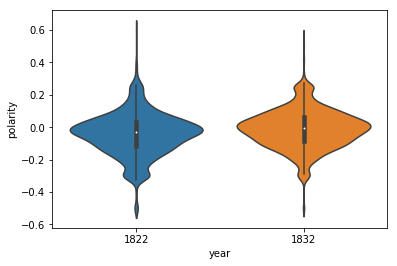

In [19]:
#SOLUTION
sns.violinplot(x="year", y="polarity", data=old_bailey);

**QUESTION:** What does this plot show us? 

What are some advantages to using polarity as a way to measure moral tone? What are some issues with this approach? Consider also how these answers might change for a different data set.

*Write your answer here.*

**SOLUTION**
The plot shows that the violin plots are about the same shape and have about the same median around 0.

Polarity is a nice metric because it's easy to calculate and interpret. It might run into issues because it will ignore words that aren't in its dictionary; this is especially an issue for this data, which has text from almost 200 years ago and may contain a significant number of more archaic words.

----
## Section 3: Moral Foundations Theory<a id='section 3'></a>

Another approach is to create specialized dictionaries containing specific words of interest to try to analyze sentiment from a particular angle (i.e. use a **dictionary method**). One set of researchers did just that from the perspective of [Moral Foundations Theory](http://moralfoundations.org/). We will now use it to see if we can understand more about the moral tone of Old Bailey transcripts than by using general polarity. You should be doing something like this for your homework. We will be using a provided moral foundations dictionary.

In [20]:
with open('data/haidt_dict.json') as json_data:
    mft_dict = json.load(json_data)

Moral Foundations Theory posits that there are five (with an occasional sixth) innane, universal psychological foundations of morality, and that those foundations shape human cultures and institutions (including legal). The keys of the dictionary correspond to the five foundations.

In [21]:
#look at the keys of the dictionary provided
keys = mft_dict.keys()
list(keys)

['authority/subversion',
 'care/harm',
 'fairness/cheating',
 'loyalty/betrayal',
 'sanctity/degradation']

And the values of the dictionary are lists of words associated with each foundation.

In [22]:
mft_dict[list(keys)[0]] #one example of the values provided for the first key

['preserve',
 'loyal',
 'betray',
 'treason',
 'traitor',
 'treacher',
 'disloyal',
 'apostasy',
 'apostate',
 'deserted',
 'deserter',
 'deserting',
 'obey',
 'obedien',
 'duty',
 'law',
 'lawful',
 'legal',
 'duti',
 'honor',
 'respect',
 'respectful',
 'respected',
 'respects',
 'order',
 'father',
 'mother',
 'motherl',
 'mothering',
 'mothers',
 'tradition',
 'hierarch',
 'authorit',
 'permit',
 'permission',
 'status',
 'rank',
 'leader',
 'class',
 'bourgeoisie',
 'caste',
 'position',
 'complian',
 'command',
 'supremacy',
 'control',
 'submi',
 'allegian',
 'serve',
 'abide',
 'defere',
 'defer',
 'revere',
 'venerat',
 'comply',
 'defian',
 'rebel',
 'dissent',
 'subver',
 'disrespect',
 'disobe',
 'sediti',
 'agitat',
 'insubordinat',
 'illegal',
 'lawless',
 'insurgent',
 'mutinous',
 'defy',
 'dissident',
 'unfaithful',
 'alienate',
 'defector',
 'heretic',
 'nonconformist',
 'oppose',
 'protest',
 'refuse',
 'denounce',
 'remonstrate',
 'riot',
 'obstruct']

### Calculating Percentages 

In this approach, we'll use the frequency of Moral Foundations-related words as a measure of how the transcripts talk about morality and see if there's a difference between pre- and post-1827 trends. 

As a first step, we need to know the total number of words in each transcript. 

**EXERCISE:** Add a column to `old_bailey` with the number of words corresponding to each transcript.

In [23]:
# create a new column called 'total_words'
old_bailey['total_words'] = ...
old_bailey.head()

,year,transcript,tokens,stemmed_tokens,polarity,total_words
trial_id,,,,,,
t18170115-1,1822,"PETER JOHNSON was indicted for being at large,...","[peter, johnson, was, indicted, for, being, at...","[peter, johnson, was, indict, for, be, at, lar...",-0.128571,Ellipsis
t18170115-2,1822,BENJAMIN HEARNE was indicted for burglariously...,"[benjamin, hearne, was, indicted, for, burglar...","[benjamin, hearn, was, indict, for, burglari, ...",0.075000,Ellipsis
t18170115-3,1822,"JOHN DAVIS and JAMES LEMON , were indicted for...","[john, davis, and, james, lemon, were, indicte...","[john, davi, and, jame, lemon, were, indict, f...",-0.027721,Ellipsis
t18170115-4,1822,"RICHARD WILTSHIRE and SUSAN PAR-SONS , were in...","[richard, wiltshire, and, susan, par, sons, we...","[richard, wiltshir, and, susan, par, son, were...",0.074495,Ellipsis
t18170115-5,1822,MARY JOHNSTON was indicted for burglariously b...,"[mary, johnston, was, indicted, for, burglario...","[mari, johnston, was, indict, for, burglari, b...",-0.033333,Ellipsis


In [24]:
# SOLUTION
old_bailey['total_words'] = old_bailey['tokens'].apply(len)
old_bailey.head()

,year,transcript,tokens,stemmed_tokens,polarity,total_words
trial_id,,,,,,
t18170115-1,1822,"PETER JOHNSON was indicted for being at large,...","[peter, johnson, was, indicted, for, being, at...","[peter, johnson, was, indict, for, be, at, lar...",-0.128571,45
t18170115-2,1822,BENJAMIN HEARNE was indicted for burglariously...,"[benjamin, hearne, was, indicted, for, burglar...","[benjamin, hearn, was, indict, for, burglari, ...",0.075000,382
t18170115-3,1822,"JOHN DAVIS and JAMES LEMON , were indicted for...","[john, davis, and, james, lemon, were, indicte...","[john, davi, and, jame, lemon, were, indict, f...",-0.027721,981
t18170115-4,1822,"RICHARD WILTSHIRE and SUSAN PAR-SONS , were in...","[richard, wiltshire, and, susan, par, sons, we...","[richard, wiltshir, and, susan, par, son, were...",0.074495,372
t18170115-5,1822,MARY JOHNSTON was indicted for burglariously b...,"[mary, johnston, was, indicted, for, burglario...","[mari, johnston, was, indict, for, burglari, b...",-0.033333,963


Next, we need to calculate the number of matches to entries in our dictionary for each foundation for each speech.

Run the next cell to add six new columns to `old_bailey`, one per foundation, that show the number of word matches. This cell will also likely take some time to run (no more than a minute). Note that by now, you have the skills to write all the code in the next cell- we're just giving it to you because it's long, fiddly, and writing nested for-loops is not the focus of this lab. Make sure you know what it does before you move on, though.

In [31]:
# Will take a bit of time to run due to the large size.

# do the following code for each foundation
for foundation in mft_dict.keys():
    # create a new, empty column
    num_match_words = np.zeros(len(old_bailey))
    stems = mft_dict[foundation]
    
    # do the following code for each foundation word
    for stem in stems:
        # find related word matches
        wd_count = np.array([sum([wd == stem for wd in transcript])for transcript in old_bailey['stemmed_tokens']])
        # add the number of matches to the total
        num_match_words += wd_count
        
    # create a new column for each foundation with the number of related words per transcript
    old_bailey[foundation] = num_match_words

old_bailey.head()

,year,transcript,tokens,stemmed_tokens,polarity,total_words,authority/subversion,care/harm,fairness/cheating,loyalty/betrayal,sanctity/degradation
trial_id,,,,,,,,,,,
t18170115-1,1822,"PETER JOHNSON was indicted for being at large,...","[peter, johnson, was, indicted, for, being, at...","[peter, johnson, was, indict, for, be, at, lar...",-0.128571,45,1.0,0.0,0.0,0.0,0.0
t18170115-2,1822,BENJAMIN HEARNE was indicted for burglariously...,"[benjamin, hearne, was, indicted, for, burglar...","[benjamin, hearn, was, indict, for, burglari, ...",0.075000,382,0.0,1.0,0.0,0.0,0.0
t18170115-3,1822,"JOHN DAVIS and JAMES LEMON , were indicted for...","[john, davis, and, james, lemon, were, indicte...","[john, davi, and, jame, lemon, were, indict, f...",-0.027721,981,0.0,0.0,0.0,0.0,0.0
t18170115-4,1822,"RICHARD WILTSHIRE and SUSAN PAR-SONS , were in...","[richard, wiltshire, and, susan, par, sons, we...","[richard, wiltshir, and, susan, par, son, were...",0.074495,372,0.0,0.0,0.0,0.0,0.0
t18170115-5,1822,MARY JOHNSTON was indicted for burglariously b...,"[mary, johnston, was, indicted, for, burglario...","[mari, johnston, was, indict, for, burglari, b...",-0.033333,963,1.0,0.0,0.0,0.0,0.0


**EXERCISE:** The columns for each foundation currently contain the number of words related to that foundation for each of the trials. Calculate the *percentage* of foundation words per trial by dividing the number of matched words by the number of total words and multiplying by 100.

In [32]:
# do this for each foundation column
for foundation in mft_dict.keys():
    old_bailey[foundation] = old_bailey[foundation] # fill in your code to transform the values here

old_bailey.head()

,year,transcript,tokens,stemmed_tokens,polarity,total_words,authority/subversion,care/harm,fairness/cheating,loyalty/betrayal,sanctity/degradation
trial_id,,,,,,,,,,,
t18170115-1,1822,"PETER JOHNSON was indicted for being at large,...","[peter, johnson, was, indicted, for, being, at...","[peter, johnson, was, indict, for, be, at, lar...",-0.128571,45,1.0,0.0,0.0,0.0,0.0
t18170115-2,1822,BENJAMIN HEARNE was indicted for burglariously...,"[benjamin, hearne, was, indicted, for, burglar...","[benjamin, hearn, was, indict, for, burglari, ...",0.075000,382,0.0,1.0,0.0,0.0,0.0
t18170115-3,1822,"JOHN DAVIS and JAMES LEMON , were indicted for...","[john, davis, and, james, lemon, were, indicte...","[john, davi, and, jame, lemon, were, indict, f...",-0.027721,981,0.0,0.0,0.0,0.0,0.0
t18170115-4,1822,"RICHARD WILTSHIRE and SUSAN PAR-SONS , were in...","[richard, wiltshire, and, susan, par, sons, we...","[richard, wiltshir, and, susan, par, son, were...",0.074495,372,0.0,0.0,0.0,0.0,0.0
t18170115-5,1822,MARY JOHNSTON was indicted for burglariously b...,"[mary, johnston, was, indicted, for, burglario...","[mari, johnston, was, indict, for, burglari, b...",-0.033333,963,1.0,0.0,0.0,0.0,0.0


In [33]:
#SOLUTION
for foundation in mft_dict.keys():
    old_bailey[foundation] = (old_bailey[foundation] / old_bailey['total_words']) * 100

old_bailey.head()

,year,transcript,tokens,stemmed_tokens,polarity,total_words,authority/subversion,care/harm,fairness/cheating,loyalty/betrayal,sanctity/degradation
trial_id,,,,,,,,,,,
t18170115-1,1822,"PETER JOHNSON was indicted for being at large,...","[peter, johnson, was, indicted, for, being, at...","[peter, johnson, was, indict, for, be, at, lar...",-0.128571,45,2.222222,0.00000,0.0,0.0,0.0
t18170115-2,1822,BENJAMIN HEARNE was indicted for burglariously...,"[benjamin, hearne, was, indicted, for, burglar...","[benjamin, hearn, was, indict, for, burglari, ...",0.075000,382,0.000000,0.26178,0.0,0.0,0.0
t18170115-3,1822,"JOHN DAVIS and JAMES LEMON , were indicted for...","[john, davis, and, james, lemon, were, indicte...","[john, davi, and, jame, lemon, were, indict, f...",-0.027721,981,0.000000,0.00000,0.0,0.0,0.0
t18170115-4,1822,"RICHARD WILTSHIRE and SUSAN PAR-SONS , were in...","[richard, wiltshire, and, susan, par, sons, we...","[richard, wiltshir, and, susan, par, son, were...",0.074495,372,0.000000,0.00000,0.0,0.0,0.0
t18170115-5,1822,MARY JOHNSTON was indicted for burglariously b...,"[mary, johnston, was, indicted, for, burglario...","[mari, johnston, was, indict, for, burglari, b...",-0.033333,963,0.103842,0.00000,0.0,0.0,0.0


Let's compare the average percentage of foundation words per transcript for the two dates, 1822, and 1832.

**EXERCISE**: Create a dataframe that only has columns for the five foundations plus the year. Then, use the pandas dataframe function `groupby` to group rows by the year, and call the `mean` function on the `groupby` output to get the averages for each foundation.

In [34]:
# the names of the columns we want to keep
mft_columns = ['authority/subversion', 'care/harm', 'fairness/cheating', 'loyalty/betrayal',
 'sanctity/degradation', 'year']

# create a data frame with only the above columns included
mft_df = ...

# groups the rows of mft_df by year, then take the mean
foundation_avgs = ...

foundation_avgs

Ellipsis

In [35]:
# SOLUTION
# the names of the columns we want to keep
mft_columns = ['authority/subversion', 'care/harm', 'fairness/cheating', 'loyalty/betrayal',
 'sanctity/degradation', 'year']

# create a data frame with only the above columns included
mft_df = old_bailey.loc[:, mft_columns]

# groups the rows by year, then take the mean
foundation_avgs = mft_df.groupby('year').mean()

foundation_avgs

,authority/subversion,care/harm,fairness/cheating,loyalty/betrayal,sanctity/degradation
year,,,,,
1822,0.078470,0.205310,0.014769,0.013650,0.027381
1832,0.146665,0.099239,0.013073,0.012185,0.042233


Next, create a bar graph. The simplest way is to call `.plot.barh()` on your dataframe of the averages. 

Also try calling `.transpose()` on your averages dataframe, then making a bar graph of that. The transpose function flips the rows and columns and can make it easier to compare the percentages.

In [36]:
# create a bar graph
...

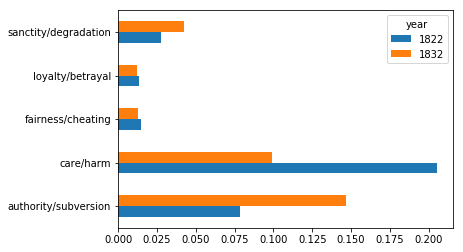

In [37]:
# SOLUTION
# create a bar graph
foundation_avgs.transpose().plot.barh()

**QUESTION:** What do you see from the bar graphs you created? 

Why would this be a good approach to answering the question of how talk about morality changed between these two periods? What are some limitations of this approach (Hint: look at the values on the graphs you calculated, and remember: these are *percentages*, not proportions)?

*Write your answer here.*

*Potential answer: The proportion of care/harm words is greater before the repeal, and the proportion of authority/subversion words is greater after the repeal. Rarity of words means results may not be significant. And, since this dictionary was not designed specifically for this data set, it also may be missing relevant words.*

----
## Section 4: Non-negative matrix factorization<a id='section 4'></a>

In this section, you can get an idea of sentiment using topic modeling algorithms, something you touched on in the 4/10 lab earlier this week, to help look for patterns.

On Tuesday, you explored Latent Dirichlet Allocation (LDA) in gensim to look for topics in a corpus. Non-negative matrix factorization (NMF), not included in gensim, is another such way to look for topics in unstructured text data. The two methods differ in what kinds of math they use 'under the hood': LDA relies on probabilistic graphical modeling, while NMF uses linear algebra. 

We want to generate the topics found for 1822 and 1832 trials, look for topics related to tone or morality, and see if there's a difference between the two.

Run the cell below to make two lists: one list of the trial transcripts for each year.

In [38]:
# trial transcripts for 1822
transcripts_1822 = old_bailey[old_bailey['year'] == 1822]['transcript']

# trial transcripts for 1832
transcripts_1832 = old_bailey[old_bailey['year'] == 1832]['transcript']

We'll start by looking at 1822. The following cell creates the tfidf vectorizer, fits the text data, and assigns the list of feature name (i.e. the words in the document) to `tfidf_feature_names_1822`.

Check out the [documentation for TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) if you need a refresher on what it does.

In [39]:
# create the vectorizer
tfidf_vectorizer_1822 = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
# fit the data
tfidf_1822 = tfidf_vectorizer_1822.fit_transform(transcripts_1822)
# get the feature names
tfidf_feature_names_1822 = tfidf_vectorizer_1822.get_feature_names()

**EXERCISE:** Create the TfidfVectorizer, fit_transform the data, and get the feature names for 1832.

In [40]:
# create the vectorizer
tfidf_vectorizer_1832 = ...
# fit the data
tfidf_1832 = ...
# get the feature names
tfidf_feature_names_1832 = ...

In [41]:
# SOLUTION
tfidf_vectorizer_1832 = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tfidf_1832 = tfidf_vectorizer_1832.fit_transform(transcripts_1832)
tfidf_feature_names_1832 = tfidf_vectorizer_1832.get_feature_names()

As mentioned previously the algorithms are not able to automatically determine the number of topics and this value must be set when running the algorithm. Initialising NMF with ‘nndsvd’ rather than random initialisation improves the time it takes for NMF to converge.`random_state` gives the seed for the random number generator to use: this lets us reproduce our results in the future.


In [42]:
num_topics = 20
# Run NMF for 1822
nmf_1822 = NMF(n_components=num_topics, random_state=1, init='nndsvd').fit(tfidf_1822)

**EXERCISE:** Run NMF using `num_topics` for the number of components on the data from 1832.

In [43]:
# Run NMF for 1832
nmf_1832 = ...

In [44]:
# SOLUTION
nmf_1832 = NMF(n_components=num_topics, random_state=1, init='nndsvd').fit(tfidf_1832)

We've provided you the function to display the topics shown by the NMF.

In [46]:
def display_topics(model, feature_names, num_top_words):
    """Displays NUM_TOP_WORDS topics for MODEL """
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

# the number of words to display per topic
num_top_words = 10

# display the topics for 1822
display_topics(nmf_1822, tfidf_feature_names_1822, num_top_words)


Topic 0:
said asked did told went came prisoner man examined cross
Topic 1:
value 1s things 2s pair 6d indictment articles box stated
Topic 2:
notes note bank 1l money book pocket 5l paid 10l
Topic 3:
forged note england pleaded possession bank having fourteen knowing feloniously
Topic 4:
watch chain prisoner key value seals person prosecutor ran watchman
Topic 5:
offence pleaded like fourteen transported years recorder prisoner middlesex second
Topic 6:
common sergeant london henry january september discharged david fined james
Topic 7:
handkerchief pocket person hand turned saw round felt life gentleman
Topic 8:
shoes pair boots shoemaker shop stockings wilson bought william breeches
Topic 9:
shop saw door prisoner privately man yards ran cotton coat
Topic 10:
acquitted appearing prosecutor middlesex value second recorder stealing goods prosecutrix
Topic 11:
august prisoner pledged goods pledge months confined pawnbroker 4th produced
Topic 12:
lead fixed house roof building belonging

In [47]:
# display the topics for 1832
display_topics(nmf_1832, tfidf_feature_names_1832, num_top_words)

Topic 0:
house went door room bed clock night stairs open came
Topic 1:
handkerchief pocket prisoner saw person felt turned gentleman took hand
Topic 2:
value 1s 6d 2s pair 5s articles goods 4s things
Topic 3:
shop prisoner saw took ran street door william yards aged
Topic 4:
watch prisoner chain seal prosecutor key value person june hand
Topic 5:
shoes pair pairs shoemaker william shoe george prisoner 21st joseph
Topic 6:
money half shillings sovereign crowns monies crown prisoner shilling pocket
Topic 7:
pleaded sergeant jury middlesex common new mr court arabin confined
Topic 8:
mr did prisoner examined cross paid know time received money
Topic 9:
coat prisoner waistcoat cab april street william george september charles
Topic 10:
said asked went came did told man got going wanted
Topic 11:
box prisoner key things handkerchiefs room articles stockings said searched
Topic 12:
boots pair trousers shop prisoners shoemaker thomas took 24th 12th
Topic 13:
purse sovereigns pocket hand bag 

As in LDA, it often takes some hyperparameter tuning before you get a coherent set of topics. Go back and tune the parameters for tfidf and NMF to see if you can get topics that show something about the moral sentiment of the transcripts. `num_topics` usually makes the most dramatic difference.

Once you've compared several sets of topics, answer the next question:

**QUESTION:** What did the best set of topics you found tell you about the tone of the documents for the two periods? Why might this approach be a good way to study sentiment? What are some issues with this approach?

*Write your answer here.*

*Potential answer: NMF can be good for uncovering patterns in unstructured data without imposing structure like in dictionary methods. But, unstructured data means you might have to dig a lot to find relevant topics.*

----
Fantastic! Now you know how to approach sentiment analysis several ways using general sentiment analysis with `VADER`, Moral Foundations Theory, and Non-negative matrix factorization.

Ultimately, there were limitations to all of these methods. In your homework, you'll explore how to generate your own dictionary to try to overcome some of these limitations.

----

## Bibliography


 - Moral Foundations Theory background and dictionary: *Jesse Graham and Jonathan Haidt http://moralfoundations.org/*
 - Moral Foundations analysis code adapted from *https://github.com/ds-modules/XRHETOR-R1A/blob/master/02-Moral-Foundations-Analysis/02-Moral-Foundations-Analysis.ipynb*
 - NMF code and explanation adapted from *Aneesha Bakharia. 'Topic Modeling With Scikit-Learn.' https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730*

----
Notebook developed by: Gibson Chu, Keeley Takimoto

Data Science Modules: http://data.berkeley.edu/education/modules